In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
from pytorch_pretrained_vit import ViT
from torchvision import transforms
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
model = ViT('B_16', num_classes=37)
model.load_state_dict(torch.load('best_acc.pth'))
model = model.cuda()

In [3]:
class PetDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.transform = transform
        self.data_path = data_path
        self.filename = [file_path for file_path in os.listdir(self.data_path)]
    
    def __len__(self):
        return len(self.filename)
    
    def __getitem__(self, index):
        image = Image.open(os.path.join(self.data_path, self.filename[index])).convert('RGB')
        label = int(self.filename[index].split('_')[0])
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [4]:
data_transform = transforms.Compose([
        transforms.Resize(model.image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

In [5]:
validSet = PetDataset(os.path.join('hw3_data', 'p1_data', 'val'), data_transform)
val_loader = DataLoader(dataset=validSet, batch_size=64, shuffle=False, num_workers=1)

In [6]:
def eval_one_epoch(model, data_loader):
    model.eval()
    valid_acc = 0
    total = 0
    for i, (inputs, labels) in enumerate(data_loader):
        with torch.no_grad():
            inputs, labels = inputs.cuda(), labels.cuda()
            logits = model(inputs)
                
#         loss = criterion(logits, labels)
        acc = (logits.argmax(dim=-1) == labels).float().sum()
        total += len(inputs)
        valid_acc += acc
    
    val_acc = valid_acc / total
    return val_acc

In [7]:
val_acc = eval_one_epoch(model, val_loader)
print(f"[ Valid | acc = {val_acc:.5f}")

[ Valid | acc = 0.94133


In [8]:
image_path = os.path.join('hw3_data', 'p1_data', 'val', '31_4838.jpg')
image1 = Image.open(image_path).convert('RGB')
data_transform = transforms.Compose([
        transforms.Resize(model.image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])
image = data_transform(image1)
image = image.unsqueeze(0).cuda()

In [9]:
logits = model(image)

In [10]:
blocks = model.transformer.blocks

In [11]:
import cv2
att_mat = []
for i in range(len(blocks)):
    att_mat.append(blocks[i].attn.scores)

att_mat = torch.stack(att_mat).squeeze(1).cpu().detach()
print(att_mat.shape)
# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)
print(att_mat.shape)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
result = cv2.resize(mask / mask.max(), image1.size).astype('double')

torch.Size([12, 12, 197, 197])
torch.Size([12, 197, 197])


In [12]:
# fig, ax= plt.subplots(figsize=(16, 16))
# ax.set_title('Attention Map Last Layer')
# im = ax.imshow(result)
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax)
# plt.show()

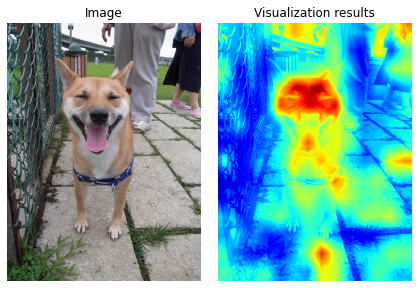

In [13]:
image1 = Image.open(image_path).convert('L')
original_image = Image.open(image_path).convert('RGB')
image1 = np.array(image1).astype("double")
image1 = image1 / 255.0
result = cv2.addWeighted(image1, 0.2, result, 0.8, 0)

fig = plt.figure()
axes = []
axes.append(fig.add_subplot(1,2,1))
axes[-1].set_title('Image')
plt.imshow(original_image)
plt.axis('off')

axes.append(fig.add_subplot(1,2,2))
axes[-1].set_title('Visualization results')
plt.imshow(result, cmap=plt.get_cmap('jet'))
plt.axis('off')
fig.tight_layout()
fig.savefig('demo3.png')
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# fig, ax= plt.subplots(figsize=(16, 16))
# ax.set_title('Attention Map Last Layer')
# im = ax.imshow(result, cmap=plt.get_cmap('jet'))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# plt.colorbar(im, cax=cax)
# plt.show()